In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

# Configuration

In [2]:
data_path = '/kaggle/input/file-csv/File CSV/MIT-BIH/'
window_input= 40
window_out= 40
train_size = 0.8
test_size = 1 - train_size
data_set = {
  0: "testset",
  1: "trainset"
}

# Start

## DỰ ĐOÁN TÍN HIỆU ECG

In [3]:
def get_data(istrainset):    
    missing_file = 0
    total_sample = 0
    directory = f"{data_path}{data_set[istrainset]}/"
    X, y = [], []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            df = pd.read_csv(f, header=None)
            data=df.drop(columns=187)
            data=data.values
            # Số lượng lặp qua dữ liệu
            num_samples = len(data) - window_input - window_out + 1
            # print("----------------------")
            # print("🍒Len data:", len(data))
            # print("🍒Num_samples:", num_samples)
            # Đối với tập train
            # Tạo dữ liệu train từ cửa sổ trượt
            if(num_samples>0):
                total_sample = total_sample + num_samples
                for i in range(num_samples):
                    X_window = data[i:i+window_input]
                    y_window = data[i+window_input:i+window_input+window_out]

                    X.append(X_window)
                    y.append(y_window)
            else:
                missing_file = missing_file + 1
    print(f"Num of file can not use due to its missing of length: {missing_file}")
    print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
    return X,y

In [4]:
X_train, y_train = get_data(1)
X_test, y_test = get_data(0)

Num of file can not use due to its missing of length: 0
Number of sample: 111156/111156/111156
Num of file can not use due to its missing of length: 1
Number of sample: 31302/31302/31302


In [5]:
print(f"Len(X_train/y_train): {len(X_train)}/{len(y_train)}")
print(f"Len(X_test/y_test): {len(X_test)}/{len(y_test)}")
print(f"Test Rate: ",len(X_test)/(len(X_train)+len(X_test)))
print(f"Train Rate: ",len(X_train)/(len(X_train)+len(X_test)))

Len(X_train/y_train): 111156/111156
Len(X_test/y_test): 31302/31302
Test Rate:  0.2197279198079434
Train Rate:  0.7802720801920566


In [6]:
# X_train= np.array(X_train)
# y_train= np.array(y_train)
# X_test= np.array(X_test)
# y_test= np.array(y_test)

In [7]:
class Dataset:
    def __init__(self, data, label):
        self.data = np.array(data)
        self.label = np.array(label)

        self.label= self.label.reshape(-1, 40*187)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        X = self.data[i]
        y = self.label[i]
        return X, y

In [8]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size= size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size //self.batch_size

In [9]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

In [10]:
train_loader = Dataloader(train_dataset, 32,len(train_dataset))
test_loader = Dataloader(test_dataset,32,len(test_dataset))

In [11]:
# Tạo một mô hình LSTM
model = Sequential()
model.add(LSTM(64,activation='relu' ,input_shape=(40, 187)))  # Đặt input_shape phù hợp với kích thước của mảng X_train
model.add(Dense(40*187))  # Đặt lớp Dense phù hợp với kích thước của mảng y_train
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit_generator(train_loader, validation_data=test_loader, epochs=1, verbose=1)

/tmp/ipykernel_32/203222965.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_loader, validation_data=test_loader, epochs=1, verbose=1)


3473/3473 [==============================] - 100s 28ms/step - loss: 0.0219 - val_loss: 0.0230


In [13]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(test_dataset[:][0])

979/979 [==============================] - 9s 9ms/step


### Đánh giá độ chính xác mô hình

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# Độ đo Mean Squared Error (MSE)
mse = mean_squared_error(test_dataset[:][1], y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Độ đo R-squared (R2)
r2 = r2_score(test_dataset[:][1], y_pred)
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.022960287014988135
R-squared (R2): -0.06321097502405802


Trực quan 

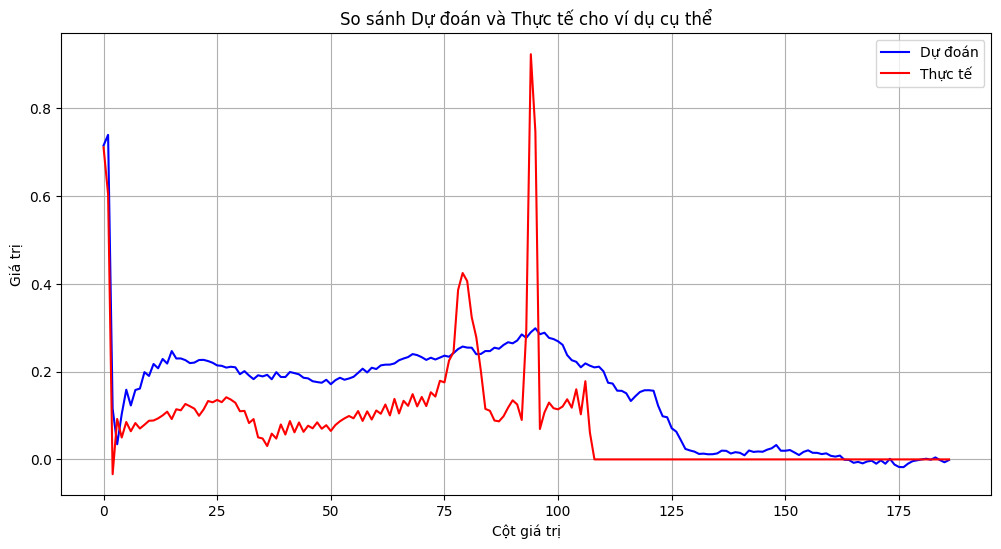

In [15]:
import matplotlib.pyplot as plt

# Chọn một ví dụ cụ thể để trực quan hóa
example_index = 40  # Thay đổi chỉ số ví dụ nếu cần

# Lấy giá trị dự đoán và giá trị thực tế tương ứng
y_pred_example = y_pred[example_index].reshape(40, 187)
y_test_example = y_test[example_index].reshape(40, 187)

# Vẽ biểu đồ cho giá trị dự đoán (màu xanh) và giá trị thực tế (màu đỏ)
plt.figure(figsize=(12, 6))
plt.plot(y_pred_example[0], label='Dự đoán', color='blue')
plt.plot(y_test_example[0], label='Thực tế', color='red')
plt.xlabel('Cột giá trị')
plt.ylabel('Giá trị')
plt.title('So sánh Dự đoán và Thực tế cho ví dụ cụ thể')
plt.legend()
plt.grid()
plt.show()


#### Giải phóng dữ liệu (Không hiệu quả)

In [16]:
import gc
# Giải phóng dữ liệu đào tạo và kiểm tra
train_loader = None
test_loader = None
train_dataset=None
test_dataset=None
model=None
# Sử dụng garbage collection để giải phóng bộ nhớ
gc.collect()

5768

In [17]:
import psutil
import os

# Lấy ID quá trình Python hiện tại
current_process = psutil.Process(os.getpid())

# Giải phóng bộ nhớ
current_process.memory_info()._asdict()  # Lấy thông tin bộ nhớ trước khi giải phóng
model = None  # Xóa tham chiếu đến mô hình
gc.collect()  # Sử dụng garbage collection để giải phóng bộ nhớ

# Kiểm tra lại thông tin bộ nhớ sau khi giải phóng
current_process.memory_info()._asdict()


{'rss': 19799412736,
 'vms': 23416803328,
 'shared': 300412928,
 'text': 2121728,
 'lib': 0,
 'data': 20244852736,
 'dirty': 0}

In [18]:
y_pred

array([[ 6.7262018e-01,  7.3707765e-01,  1.5465796e-01, ...,
         1.6107809e-03, -1.8880097e-04,  2.0862501e-03],
       [ 6.8642700e-01,  7.6535130e-01,  1.7670122e-01, ...,
         6.3375465e-04, -1.5817157e-03,  2.5099416e-03],
       [ 6.9485986e-01,  7.5522232e-01,  1.5844533e-01, ...,
         2.5841082e-03, -7.1328715e-04,  2.6822379e-03],
       ...,
       [ 6.7816460e-01,  7.6916420e-01,  3.4440655e-01, ...,
        -2.3528608e-04, -8.0733513e-04,  1.7412473e-05],
       [ 6.8723118e-01,  7.7943337e-01,  3.4842116e-01, ...,
         3.5943161e-04, -1.9464516e-03, -1.5640492e-04],
       [ 6.9134784e-01,  7.8267026e-01,  3.4484079e-01, ...,
         1.1615240e-03, -2.2131321e-03,  2.1790387e-04]], dtype=float32)

## PHÂN LỚP TÍN HIỆU ECG TƯƠNG LAI

### Preprocesing

In [19]:
def get_data_class(istrainset):    
    missing_file = 0
    total_sample = 0
    directory = f"{data_path}{data_set[istrainset]}/"
    X, y = [], []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            df = pd.read_csv(f, header=None)
            data=df.values
            # Số lượng lặp qua dữ liệu
            num_samples = len(data) - window_input - window_out + 1
            # print("----------------------")
            # print("🍒Len data:", len(data))
            # print("🍒Num_samples:", num_samples)
            # Đối với tập train
            # Tạo dữ liệu train từ cửa sổ trượt
            if(num_samples>0):
                total_sample = total_sample + num_samples
                for i in range(num_samples):
                    X_window = data[i:i+window_input,:-1]
                    y_window = data[i+window_input:i+window_input+1,-1]

                    X.append(X_window)
                    y.append(y_window)
            else:
                missing_file = missing_file + 1
    print(f"Num of file can not use due to its missing of length: {missing_file}")
    print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
    return X,y

In [20]:
X_class_train, y_class_train = get_data_class(1)

Num of file can not use due to its missing of length: 0
Number of sample: 111156/111156/111156


In [21]:
y_class_train= np.concatenate(y_class_train, axis=0)

In [22]:
y_class_train.shape

(111156,)

In [23]:
y_class_train=y_class_train.astype(int)

In [24]:
X_class_train= np.array(X_class_train)

In [25]:
n=X_class_train.shape[0]


In [26]:
X_class_train=X_class_train.reshape(n,40*187)
X_class_train.shape

(111156, 7480)

In [27]:
k=y_pred.shape[0]

In [28]:
#ECG dự đoán phân lớp X_class_test
X_class=y_pred.reshape(k,40,187)
X_class_test=X_class.reshape(X_class.shape[0],40*187)
X_class_test.shape


(31302, 7480)

In [29]:
def get_data_class2(istrainset):    
    missing_file = 0
    total_sample = 0
    directory = f"{data_path}{data_set[istrainset]}/"
    X, y = [], []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            df = pd.read_csv(f, header=None)
            data=df.values
            # Số lượng lặp qua dữ liệu
            num_samples = len(data) - window_input - window_out + 1
            # print("----------------------")
            # print("🍒Len data:", len(data))
            # print("🍒Num_samples:", num_samples)
            # Đối với tập train
            # Tạo dữ liệu train từ cửa sổ trượt
            if(num_samples>0):
                total_sample = total_sample + num_samples
                for i in range(num_samples):
                    y_window = data[i+window_input*2:i+window_input*2+1,-1]
                    y.append(y_window)
            else:
                missing_file = missing_file + 1
    print(f"Num of file can not use due to its missing of length: {missing_file}")
    print(f"Number of sample: {len(X)}/{total_sample}")
    return y

In [30]:
y_class= get_data_class2(0)

Num of file can not use due to its missing of length: 1
Number of sample: 0/31302


In [31]:
#Xác định y_test_class ban đầu
y_class=np.concatenate(y_class)
y_class_test=y_class.astype(int)

In [32]:
print(X_class_train.shape)
print(y_class_train.shape)
print(X_class_test.shape)
print(y_class_test.shape)

(111156, 7480)
(111156,)
(31302, 7480)
(31285,)


In [31]:
# import numpy as np

# unique_values, counts = np.unique(y_class_train, return_counts=True)

# for value, count in zip(unique_values, counts):
#     print(f"{value}: {count}")

### Mô hình đơn

#### Mô hình LSTM

In [33]:
# Bước: Xây dựng mô hình LSTM
input_shape = (X_class_train.shape[1], 1)

model_lstm= Sequential()
model_lstm.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(5, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_lstm.fit(X_class_train.reshape(X_class_train.shape[0], X_class_train.shape[1], 1), y_class_train, epochs=10, batch_size=32)

#Note Bắt đầu bị tràn RAM tại model_lstm.fit() ko thể thực hiện tiếp 

In [ ]:
predictions = model_lstm.predict(X_class_test)
y_pred_classes = np.argmax(predictions, axis=1)

##### ĐÁNH GIÁ MÔ HÌNH

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_class_test, y_pred_classes)
accuracy

Sensitivity

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
cm = confusion_matrix(y_class_test, y_pred_classes)
cm

In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, y_pred_classes == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, y_pred_classes == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, y_pred_classes == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, y_pred_classes == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, y_pred_classes == 4)

In [ ]:
import matplotlib.pyplot as plt

# Sử dụng recall_score để tính sensitivity cho từng lớp
from sklearn.metrics import recall_score

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


Precision

In [ ]:
from sklearn.metrics import classification_report
# Lấy báo cáo phân loại cho các lớp
report = classification_report(y_class_test, y_pred_classes)
print(report)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Khởi tạo mô hình KNeighborsClassifier với số hàng xóm (neighbors) cần xem xét
knn_model = KNeighborsClassifier(n_neighbors=5)  # Tuỳ chỉnh số hàng xóm nếu cần
knn_model.fit(X_class_train, y_class_train)

In [ ]:
predictions = knn_model.predict(X_class_test)

##### Đánh giá mô hình

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_class_test, predictions)
accuracy

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

import matplotlib.pyplot as plt

# Sử dụng recall_score để tính sensitivity cho từng lớp
from sklearn.metrics import recall_score

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Khởi tạo mô hình KNeighborsClassifier với số hàng xóm (neighbors) cần xem xét
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Tuỳ chỉnh số cây (n_estimators) nếu cần

In [ ]:
rf_model.fit(X_class_train, y_class_train)

In [ ]:
predictions = rf_model.predict(X_class_test)

##### Danh gia mo hinh

In [ ]:
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


#### Decision Tree

##### Xây dựng mô hình

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo mô hình DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(X_class_train, y_class_train)

In [ ]:
predictions = dt_model.predict(X_class_test)

##### Đánh giá mô hình

In [ ]:
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


#### LogisticRegression

##### Xay dung mo hinh

In [ ]:
from sklearn.linear_model import LogisticRegression
# Khởi tạo mô hình Logistic Regression
logistic_model = LogisticRegression()
# Huấn luyện mô hình trên tập huấn luyện
logistic_model.fit(X_class_train, y_class_train)

In [ ]:
predictions = logistic_model.predict(X_class_test)

##### Danh gia mo hinh

In [ ]:
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


#### NaiveBayes

##### Xay dung mo hinh

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Khởi tạo mô hình Naive Bayes (Gaussian Naive Bayes)
nb_model = GaussianNB()
# Huấn luyện mô hình trên tập huấn luyện
nb_model.fit(X_class_train, y_class_train)

In [ ]:
predictions = nb_model.predict(X_class_test)

##### Danh gia mo hinh

In [ ]:
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


#### GradientBoostingClassifier

##### Xay dung mo hinh

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
# Đào tạo mô hình Gradient Boosting trên dữ liệu huấn luyện
gb_model.fit(X_class_train, y_class_train)

In [ ]:
# Dự đoán với mô hình đã đào tạo
predictions = gb_model.predict(X_class_test)

##### Danh gia mo hinh

In [ ]:
report = classification_report(y_class_test, predictions)
print(report)

In [ ]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_class_test, predictions)
# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
sensitivity_class_0 = recall_score(y_class_test == 0, predictions == 0)
sensitivity_class_1 = recall_score(y_class_test == 1, predictions == 1)
sensitivity_class_2 = recall_score(y_class_test == 2, predictions == 2)
sensitivity_class_3 = recall_score(y_class_test == 3, predictions == 3)
sensitivity_class_4 = recall_score(y_class_test == 4, predictions == 4)

# Giả sử bạn đã tính được sensitivity cho các lớp
sensitivity_scores = [sensitivity_class_0,sensitivity_class_1, sensitivity_class_2, sensitivity_class_3, sensitivity_class_4]

# Tên của các lớp
class_names = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1 để hiển thị độ nhạy từ 0% đến 100%
plt.show()


### Kết hợp mô hình Boosting

LSTM-GradientBoosting

LSTM-CatBoost

LSTM- XGBoost

### Kết hợp theo hướng Stacking

LSTM-RF

Trực quan